In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c spaceship-titanic

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat '/content/kaggle.json': No such file or directory
spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extracting data

In [3]:
zip_ref = zipfile.ZipFile("/content/spaceship-titanic.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
from typing import List
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

class ModelData:
  def __init__(self, df):
    self.df_model = df

  def return_dataframe(self):
    return self.df_model

  def get_head(self):
    return self.df_model.head()

  def get_columns(self):
    return self.df_model.columns

  def get_unique(self, column):
    return self.df_model[column].unique()

  def plot_bar(self, column):
    self.df_model[column].value_counts().sort_values().plot(kind = "barh")
  
  def get_info(self):
    return self.df_model.info()
  
  def describe(self):
    return self.df_model.describe()

  def find_null_column(self) -> List:
    columns = self.df_model.columns[self.df_model.isnull().any()]
    return columns
  
  def fix_columns(self, columns:List[str] , method: str):
    if method == "mean":
      for column in columns:
        self.df_model[column].fillna(self.df_model[column].mean(), inplace=True)

  def fix_column_str(self, column):
    self.df_model[column] = self.df_model[column].replace('', "0")

  def fix_columns_values(self,column, threshold):
    for col, thr in zip(column, threshold):
      self.df_model[col] = self.df_model[col].apply(lambda x: self.df_model[col].mean() if x < thr else x)

  def count_column_condition(self, column1, column2, condition):
    '''
      Count specific value in another column (column2) when we group by column2 
      given condition that aplies to column2

      Inputs:
        -column1: Column to group by
        -column2: Column in which we trying to count elements
        -condition: given condition to column2

      Returns:
        - List of columns and count of elements for them
    '''
    return self.df_model.groupby(column1)[column2].apply(lambda x: (x == condition).sum())

  def delete_columns(self, columns: List[str]):
    for i in columns:
      self.df_model = self.df_model.drop(i, axis=1)

  def get_dtypes(self):
    return self.df_model.dtypes

  def show_corr(self):
    plt.figure(figsize=(16,16))
    sns.heatmap(data=self.df_model.corr(), annot=True, fmt=".2f")

  def show_normal_distribution(self, columns):
    for i in columns:
      col = self.df_model[i]
      mean, std_dev = norm.fit(col)
      plt.figure(figsize=(10,10))
      plt.hist(col, bins=20, density=True, alpha=0.6, color='g')
      xmin, xmax = plt.xlim()
      x = np.linspace(xmin, xmax, 100)
      p = norm.pdf(x, mean, std_dev)
      plt.plot(x, p, 'k', linewidth=2)
      title = f"Normal distribution of {i}: mean = {mean:.2f}, std dev = {std_dev:.2f}"
      plt.title(title)
      plt.show()


  def show_normal_distribution_label(self,label, columns):
    ones_label = self.df_model[self.df_model[label] == 1]
    zero_label = self.df_model[self.df_model[label] == 0]
    for i in columns:
      plt.figure(figsize=(10,10))
      ones_label[i].plot(kind="kde", color="green", title=i)
      zero_label[i].plot(kind="kde", color="red")
      plt.xlim([0,max(ones_label[i])])

  def dummies(self, columns):
    df = pd.get_dummies(self.df_model, columns = columns)
    self.df_model = df


  def min_max_scaler(self, columns):
    clf = MinMaxScaler()
    df_min_max = self.df_model[columns]
    data_transformed = clf.fit_transform(df_min_max.to_numpy())
    data_transformed = pd.DataFrame(data_transformed)
    df_one_hot = pd.concat([self.df_model.drop(columns, axis=1), data_transformed], axis=1)
    self.df_model = pd.DataFrame(df_one_hot)




In [5]:
df = pd.read_csv("/content/train.csv")
df = ModelData(df)

In [6]:
df.get_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df.find_null_column()

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name'],
      dtype='object')

In [8]:
df.get_dtypes()

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [9]:
df.get_head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [10]:
df.get_unique("HomePlanet")

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [11]:
df.get_unique("CryoSleep")

array([False, True, nan], dtype=object)

In [12]:
df.get_unique("Cabin")

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

In [13]:
df.get_unique("Destination")

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

### Show statistic of specific data

In [14]:
df.count_column_condition("Destination", "Transported", False)

Destination
55 Cancri e       702
PSO J318.5-22     395
TRAPPIST-1e      3128
Name: Transported, dtype: int64

In [15]:
df.count_column_condition("Destination", "Transported", True)

Destination
55 Cancri e      1098
PSO J318.5-22     401
TRAPPIST-1e      2787
Name: Transported, dtype: int64

In [16]:
df.count_column_condition("HomePlanet", "Transported", False)

HomePlanet
Earth     2651
Europa     727
Mars       839
Name: Transported, dtype: int64

In [17]:
df.count_column_condition("HomePlanet", "Transported", True)

HomePlanet
Earth     1951
Europa    1404
Mars       920
Name: Transported, dtype: int64

In [18]:
df.count_column_condition("CryoSleep", "Transported", False)

CryoSleep
False    3650
True      554
Name: Transported, dtype: int64

In [19]:
df.count_column_condition("CryoSleep", "Transported", True)

CryoSleep
False    1789
True     2483
Name: Transported, dtype: int64

In [20]:
df.count_column_condition("VIP", "Transported", True)

VIP
False    4198
True       76
Name: Transported, dtype: int64

In [21]:
df.count_column_condition("VIP", "Transported", False)

VIP
False    4093
True      123
Name: Transported, dtype: int64

In [22]:
df.count_column_condition("RoomService", "Transported", False)

RoomService
0.0        2045
1.0          77
2.0          47
3.0          37
4.0          38
           ... 
8209.0        1
8243.0        1
8586.0        1
9920.0        1
14327.0       1
Name: Transported, Length: 1273, dtype: int64

In [23]:
df.count_column_condition("RoomService", "Transported", True)

RoomService
0.0        3532
1.0          40
2.0          32
3.0          24
4.0           9
           ... 
8209.0        0
8243.0        0
8586.0        0
9920.0        0
14327.0       0
Name: Transported, Length: 1273, dtype: int64

In [24]:
df = pd.read_csv("/content/train.csv")
df = ModelData(df)
df_help = df.return_dataframe()
df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A/\d+/\D+', 'useless')
df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B/\d+/\D+', 'high')
df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C/\d+/\D+', 'high')
df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D/\d+/\D+', 'useless')
df_help['Cabin'] = df_help['Cabin'].str.replace(r'^E/\d+/\D+', 'low')
df_help['Cabin'] = df_help['Cabin'].str.replace(r'^T/\d+/\D+', 'useless')
df_help['Cabin'] = df_help['Cabin'].str.replace(r'^G/\d+/\D+', 'useless')
df_help['Cabin'] = df_help['Cabin'].str.replace(r'^F/\d+/\D+', 'useless')
df = ModelData(df_help)

<ipython-input-24-78fb7ce9dc41>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A/\d+/\D+', 'useless')
<ipython-input-24-78fb7ce9dc41>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B/\d+/\D+', 'high')
<ipython-input-24-78fb7ce9dc41>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C/\d+/\D+', 'high')
<ipython-input-24-78fb7ce9dc41>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D/\d+/\D+', 'useless')
<ipython-input-24-78fb7ce9dc41>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^E/\d

In [25]:
df.count_column_condition("Cabin", "Transported", True)

Cabin
high       1080
low         313
useless    2885
Name: Transported, dtype: int64

In [26]:
df.count_column_condition("Cabin", "Transported", False)

Cabin
high        446
low         563
useless    3207
Name: Transported, dtype: int64

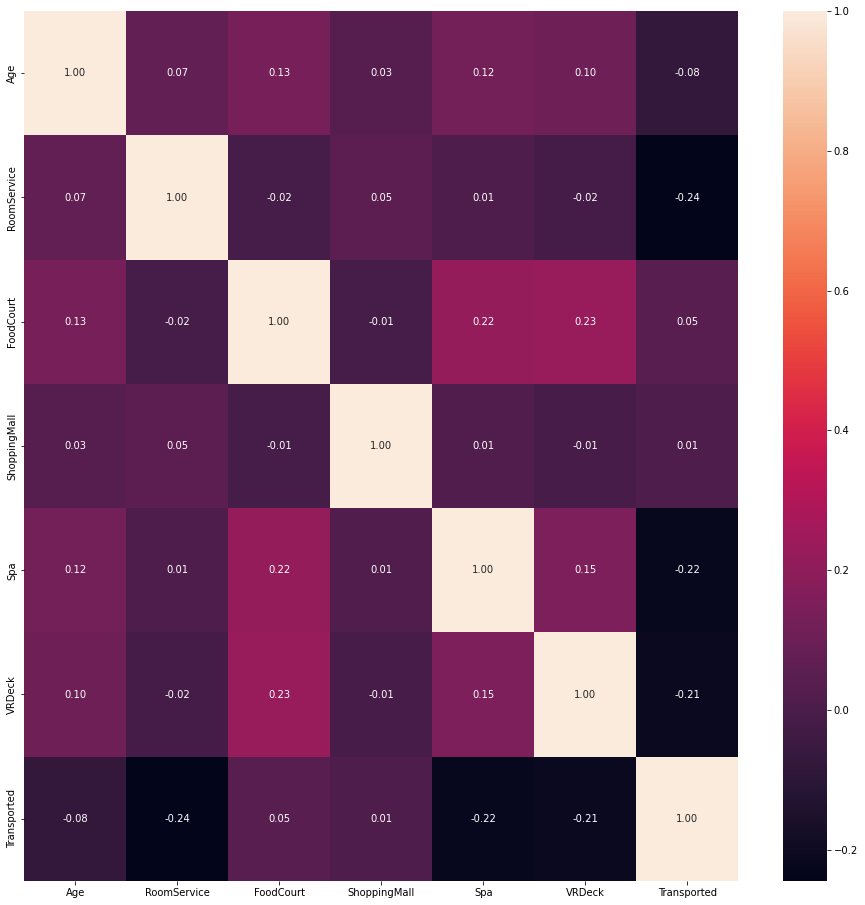

In [27]:
df.show_corr()

In [28]:
df.fix_columns(["Age", "Spa", "ShoppingMall", "FoodCourt", "VRDeck", "RoomService"], method="mean")

# ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
#        'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']

df.fix_columns_values(["Age","VRDeck","Spa","ShoppingMall","FoodCourt","RoomService"],[-0.1,-0.1,-0.1,-0.1,-0.1,-0.1])

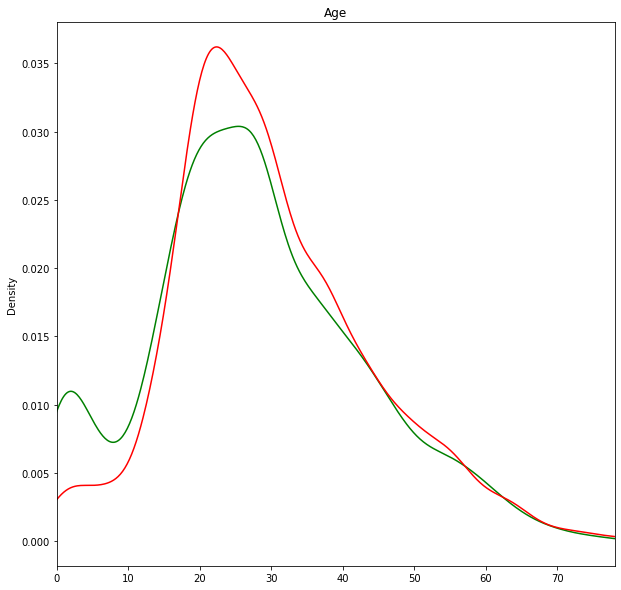

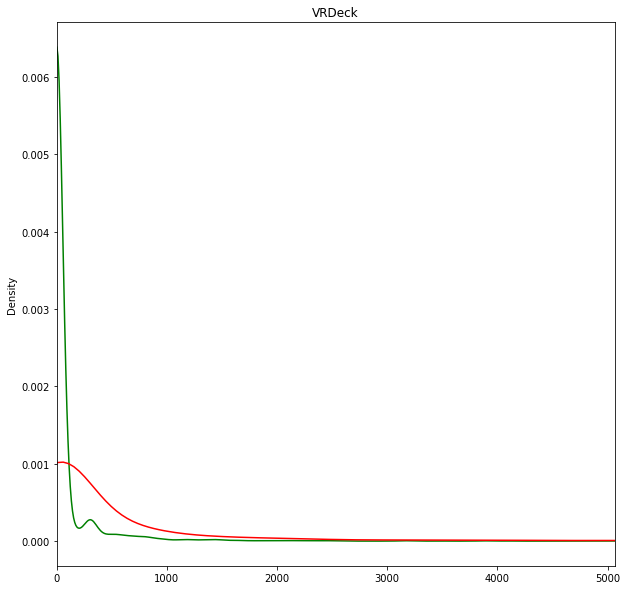

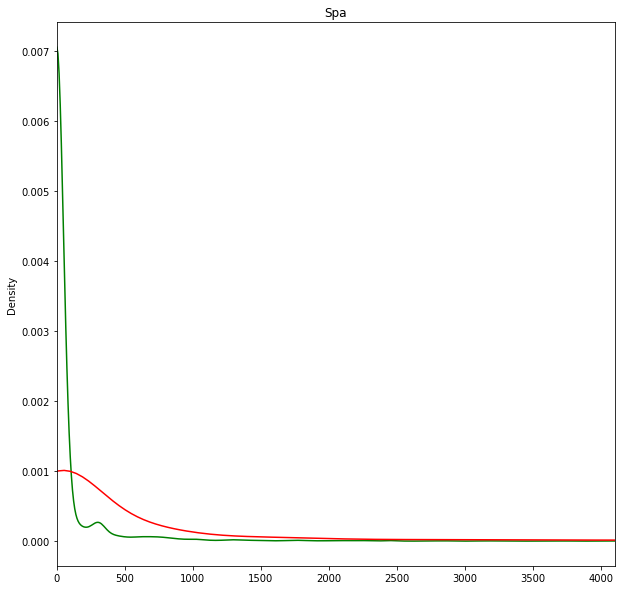

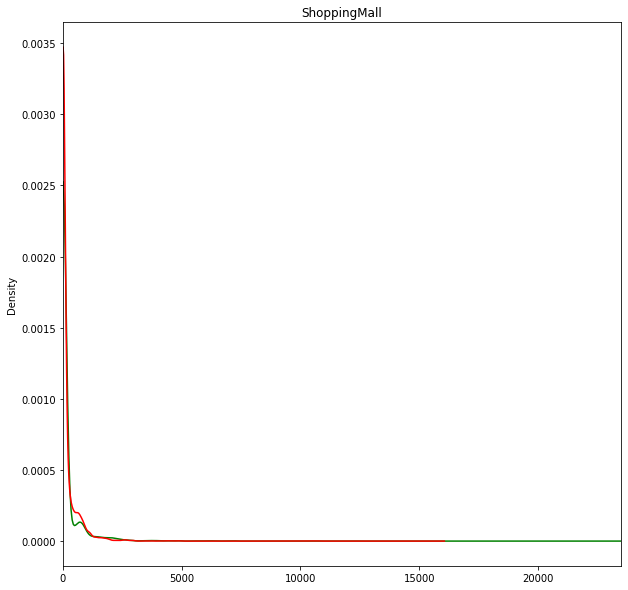

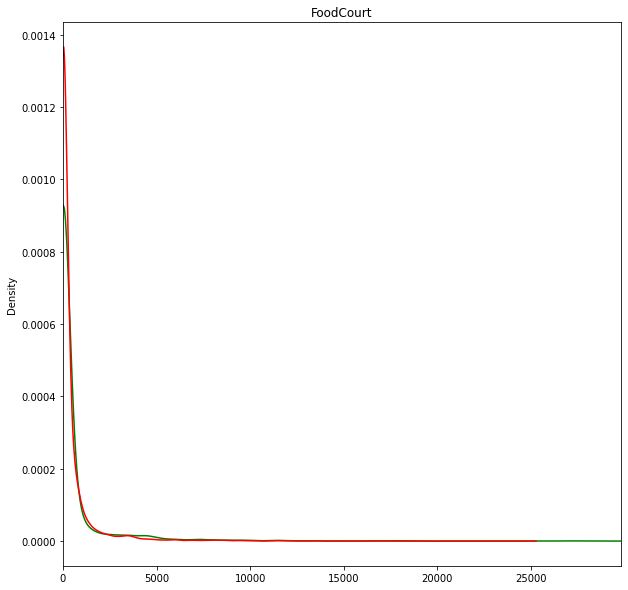

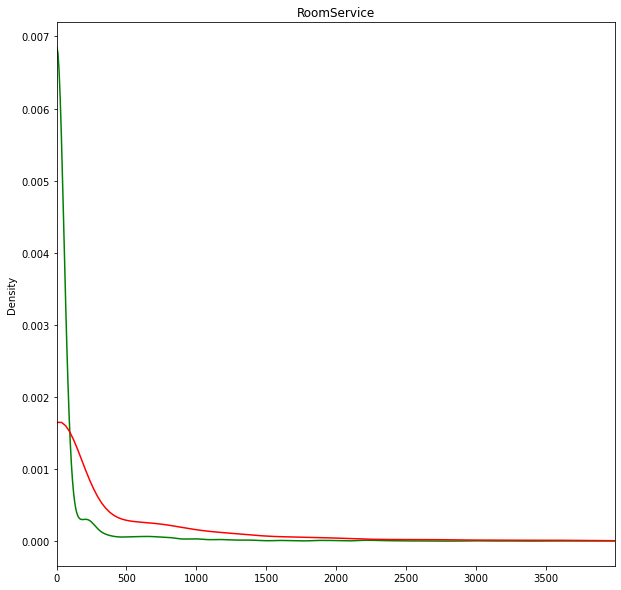

In [29]:
df.show_normal_distribution_label("Transported",["Age", "VRDeck", "Spa", "ShoppingMall", "FoodCourt", "RoomService"])

## Preparing data

In [30]:
def preparing_data(df):
  df.fix_columns(["Age", "Spa", "ShoppingMall", "FoodCourt", "VRDeck", "RoomService"], method="mean")
  df.fix_columns_values(["Age","VRDeck","Spa","ShoppingMall","FoodCourt","RoomService"],[-0.1,-0.1,-0.1,-0.1,-0.1,-0.1])
  df_help = df.return_dataframe()
  df_help["Age"] = df_help['Age'].apply(lambda x: 'low' if x < 14 else ("useless" if x < 18 else ("high" if x < 32 else "useless")))
  df_help['Spa'] = df_help['Spa'].apply(lambda x: 'low' if x < 80 else ("useless" if x < 100 else ("high" if x < 1100 else "useless")))
  df_help['VRDeck'] = df_help['VRDeck'].apply(lambda x: 'low' if x < 100 else ("middle" if x < 1300 else "useless"))
  df_help['RoomService'] = df_help['RoomService'].apply(lambda x: 'low' if x < 80 else "useless")
  df_help["ShoppingMall"] = df_help['ShoppingMall'].apply(lambda x: 'low' if x < 90 else "useless")
  df_help["FoodCourt"] = df_help['FoodCourt'].apply(lambda x: 'low' if x < 350 else "useless")

  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A/\d+/\D+', 'useless')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B/\d+/\D+', 'high')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C/\d+/\D+', 'high')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D/\d+/\D+', 'useless')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^E/\d+/\D+', 'low')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^T/\d+/\D+', 'useless')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^G/\d+/\D+', 'useless')
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^F/\d+/\D+', 'useless')

  df = ModelData(df_help)
  df.delete_columns(["PassengerId", "VIP", "Name"])
  df.dummies(["Destination","HomePlanet","CryoSleep","ShoppingMall","FoodCourt", "Spa", "VRDeck","Cabin" ,"RoomService","Age"])
  df_train = df.return_dataframe()  
  return df_train

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

class Classification():
  def __init__(self):
    self.Linear_SVC = LinearSVC()
    self.SGD_Classifier = SGDClassifier(max_iter=1000, tol=1e-3)
    self.kernel_approximation = Nystroem(n_components=100)
    self.KNeighbour_Classifier = KNeighborsClassifier()
    self.SVC = SVC()
    
  ## Linear SVC
  def create_linear_svc(self,X,y):
    param_grid = {'C': [0.1,0.3,0.5,0.7,0.9,1,2,5,10],
            'penalty': ['l2']}
    svc = LinearSVC()
    grid_search = GridSearchCV(svc, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.Linear_SVC = best_model

  def score_linear_svc(self,X,y):
    return self.Linear_SVC.score(X,y)

  def evaluate_linear_svc(self, X):
    return self.Linear_SVC.predict(X)

  def get_linear_svc(self):
    return self.Linear_SVC

  #SGD_Classifier
  def create_sgd_classifier(self,X,y):
    param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber','perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.001, 0.01, 0.1,0.5],
    'max_iter': [1000, 5000]
    }
    sgd = SGDClassifier()
    grid_search = GridSearchCV(sgd, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.SGD_Classifier = best_model

  def score_sgd_classifier(self,X,y):
    return self.SGD_Classifier.score(X,y)

  def evaluate_sgd_classifier(self, X):
    return self.SGD_Classifier.predict(X)

  def get_sgd_classifier(self):
    return self.SGD_Classifier

  ## kernel_approximation
  def create_kernel_approximation(self,X,y):
    kernel_approx = Nystroem(n_components=100)
    data = kernel_approx.fit_transform(X)
    self.create_linear_svc(data,y)
    self.kernel_approximation = self.get_linear_svc()

  def score_kernel_approximation(self,X,y):
    return self.kernel_approximation(X,y)

  def evaluate_kernel_approximation(self, X):
    return self.kernel_approximation.predict(X)

  def get_kernel_approximation(self):
    return self.kernel_approximation

  ##KNeighbour Classifier
  def create_kn_classifier(self,X,y):
    param_grid = {'n_neighbors': [2,3,5,10,15,20],
            'weights': ['uniform', 'distance']}
    knc = KNeighborsClassifier()
    grid_search = GridSearchCV(knc, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.KNeighbour_Classifier = best_model

  def score_kn_classifier(self,X,y):
    return self.KNeighbour_Classifier.score(X,y)

  def evaluate_kn_classifier(self, X):
    return self.KNeighbour_Classifier.predict(X)

  def get_kn_classifier(self):
    return self.KNeighbour_Classifier

  ##SVC
  def create_svc(self,X,y):
    param_grid = {'C': [0.1,0.2,0.3,0.4,0.5,0.7,0.8,0.9, 1,1.2,1.5,2,3,5,7,10],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma': ['scale', 'auto']}
    svc = SVC()
    grid_search = GridSearchCV(svc, param_grid, cv=5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    self.SVC = best_model

  def score_svc(self,X,y):
    return self.SVC.score(X,y)

  def evaluate_svc(self, X):
    return self.SVC.predict(X)

  def get_svc(self):
    return self.SVC

  def train_all_models(self, X,y):
    self.create_sgd_classifier(X,y)
    print("SGD_model created")
    self.create_linear_svc(X,y)
    print("Linear_SVC created")
    self.create_kn_classifier(X,y)
    print("KNeighbours created")
    self.create_svc(X,y)
    print("SVC created")

  def compare_model_all(self):
    df = pd.DataFrame(data={"Linear_SVC":self.score_kn_classifier(X,y),
                            "SGD_classifier": self.score_sgd_classifier(X,y),
                            "KNeighbour":self.score_kn_classifier(X,y),
                            "SVC": self.score_svc(X,y)},
                       index=["accuracy"])
    return df.transpose()

In [32]:
df = pd.read_csv("/content/train.csv")
df_model = ModelData(df)
df = preparing_data(df_model)
X = df.drop("Transported", axis=1)
y = df["Transported"]


<ipython-input-30-d0a3d108f469>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'

In [33]:
model = Classification()

In [34]:
model.train_all_models(X,y)

SGD_model created
Linear_SVC created
KNeighbours created
SVC created


In [35]:
model.compare_model_all()

,accuracy
Linear_SVC,0.788220
SGD_classifier,0.782469
KNeighbour,0.788220
SVC,0.796963


In [58]:
from types import prepare_class
df = pd.read_csv("/content/test.csv")
df = ModelData(df)
df = preparing_data(df)
X = df
preds = model.evaluate_svc(X)

<ipython-input-30-d0a3d108f469>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'

In [59]:
df_sub = pd.read_csv("/content/sample_submission.csv")
df_sub["Transported"] = preds

In [60]:
df_sub.to_csv('data.csv', index=False)
from google.colab import files
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Trying to use Deep Learning

In [39]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class Model_Keras_Dense:
  def __init__(self):
    self.model = tf.keras.Sequential()
    self.history = []

  def layers(self, dims, activation):
    for dim in dims:
      self.model.add(tf.keras.layers.Dense(dim, activation=activation))

  def output_layer(self, dim, activation):
    self.model.add(tf.keras.layers.Dense(dim, activation=activation))
  
  def compile(self, loss, optimizer, metrics):
    self.model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

  def train(self, x_train, y_train, x_val,y_val,epochs,batch_size=32):
    self.history = self.model.fit(x_train,
                                  y_train,
                                  epochs=epochs,
                                  batch_size=batch_size, 
                                  validation_data=(x_val,y_val))
    
  def evaluate(self, x_test, y_test):
    loss, acc = self.model.evaluate(x_test, y_test)
    return loss, acc

  def predict(self, X):
    return tf.squeeze(tf.round(self.model.predict(X)))

  def plot_history(self):
    '''
    Takes history of our model and plot accuracy and loss function

    parms:
    history - model history

    output:
    -
    '''
    loss = self.history.history["loss"]
    acc = self.history.history["accuracy"]
    number_of_elements = len(loss)
    epochs = np.linspace(1,number_of_elements,number_of_elements)

    ## Plotting functions
    fig,ax = plt.subplots(2,1, figsize=(10,7))
    ax[0].plot(epochs, acc)
    ax[0].set_title("Accuracy")  
    ax[1].plot(epochs, loss)
    ax[1].set_title("Loss function")
    plt.show()

  def show_confusion_matrix(self,X,y_true):
    pred = self.predict(X)
    confusion_matrix = confusion_matrix(y_true, pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.show()



In [40]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
df = df_test = pd.read_csv("/content/train.csv")
df = ModelData(df)
df = preparing_data(df)
X = df.drop("Transported", axis=1)
y = df["Transported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-30-d0a3d108f469>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'

In [41]:
model_1 = Model_Keras_Dense()
model_1.layers([100,100,10,10], "relu")
model_1.output_layer(1,"sigmoid")
model_1.compile("binary_crossentropy", "adam", "accuracy")
model_1.train(X_train,y_train,X_test,y_test,10)

Epoch 1/10
218/218 [==============================] - 3s 4ms/step - loss: 0.4976 - accuracy: 0.7673 - val_loss: 0.4753 - val_accuracy: 0.7769
Epoch 2/10
218/218 [==============================] - 1s 3ms/step - loss: 0.4541 - accuracy: 0.7853 - val_loss: 0.4603 - val_accuracy: 0.7786
Epoch 3/10
218/218 [==============================] - 1s 4ms/step - loss: 0.4432 - accuracy: 0.7899 - val_loss: 0.4632 - val_accuracy: 0.7792
Epoch 4/10
218/218 [==============================] - 1s 3ms/step - loss: 0.4409 - accuracy: 0.7892 - val_loss: 0.4549 - val_accuracy: 0.7798
Epoch 5/10
218/218 [==============================] - 1s 3ms/step - loss: 0.4342 - accuracy: 0.7942 - val_loss: 0.4561 - val_accuracy: 0.7769
Epoch 6/10
218/218 [==============================] - 1s 3ms/step - loss: 0.4338 - accuracy: 0.7922 - val_loss: 0.4607 - val_accuracy: 0.7775
Epoch 7/10
218/218 [==============================] - 1s 3ms/step - loss: 0.4330 - accuracy: 0.7974 - val_loss: 0.4631 - val_accuracy: 0.7786
Epoch 

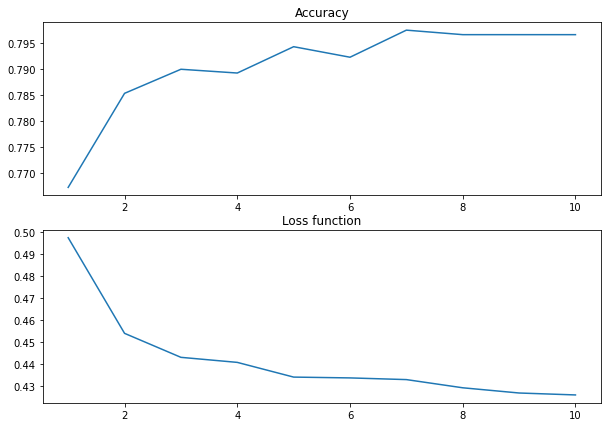

In [42]:
model_1.plot_history()

## CatClassifier

In [57]:
!pip install catboost
from catboost import CatBoostClassifier
df = pd.read_csv("/content/train.csv")
df_model = ModelData(df)
df = preparing_data(df_model)
X = df.drop("Transported", axis=1)
y = df["Transported"]


model_cat = CatBoostClassifier(iterations=1000, 
                            learning_rate=0.1, 
                            loss_function='Logloss',
                            verbose=)
model_cat.fit(X, y)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-30-d0a3d108f469>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'

TypeError: ignored

In [54]:
from sklearn.metrics import accuracy_score
from types import prepare_class
df = pd.read_csv("/content/test.csv")
df = ModelData(df)
df = preparing_data(df)
X = df
y_pred = model_cat.predict(X)

<ipython-input-30-d0a3d108f469>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^A/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^B/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^C/\d+/\D+', 'high')
<ipython-input-30-d0a3d108f469>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'^D/\d+/\D+', 'useless')
<ipython-input-30-d0a3d108f469>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_help['Cabin'] = df_help['Cabin'].str.replace(r'

In [55]:
df_sub = pd.read_csv("/content/sample_submission.csv")
df_sub["Transported"] = y_pred

In [56]:
df_sub.to_csv('data.csv', index=False)
from google.colab import files
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>